### What is Credit Card Fraud?
Credit card fraud is when someone uses another person's credit card or account information to make unauthorized purchases or access funds through cash advances.

### Problem Statement:
This model is used to identify whether a new transaction is fraudulent or not. Our aim is to detect 100% of the fraudulent transactions while minimizing the incorrect fraud classifications.

### Observations
The dataset contains transactions made by credit cards in September 2013 by European cardholders. This dataset presents transactions that occurred in two days, consisting of 492 frauds in a total of 284,807 observations. This resulted in only 0.172% fraud cases. Very few transactions are actually fraudulent (less than 1%).
It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data,so pre-analysis or feature study could not be done. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'.
Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.
There is no missing value in the dataset.

### What is the catch?
Training a model on a balanced dataset optimizes performance on validation data.
However, the goal is to optimize performance on the imbalanced production dataset. You ultimately need to find a balance that works best in production.
One solution to this problem is: Use all fraudulent transactions, but subsample non-fraudulent transactions as needed to hit our target rate.

In [6]:
pip install opendatasets

Note: you may need to restart the kernel to use updated packages.


In [7]:
import opendatasets as od
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import plotly as px
import seaborn as sns
import matplotlib
from sklearn.metrics import classification_report,accuracy_score
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM 
LABELS = ["Normal", "Fraud"]
import os
%matplotlib inline
     

In [8]:
sns.set_style('darkgrid')

plt.rcParams['figure.figsize'] =(7,5)

In [12]:
dataset_url = 'https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud?select=creditcard.csv'

In [13]:
od.download(dataset_url)

Skipping, found downloaded files in ".\creditcardfraud" (use force=True to force download)


In [14]:
os.listdir('creditcardfraud')

['creditcard.csv', 'creditcardfraud.zip']

In [15]:
df = pd.read_csv('creditcardfraud/creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0.0
1,0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0.0
2,1,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0.0
3,1,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0.0
4,2,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0.0


In [16]:
#checking shape of the dataset
df.shape

(1986, 31)

In [17]:
#checking the datatype and null/non null distribution
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1986 entries, 0 to 1985
Data columns (total 31 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Time    1986 non-null   int64  
 1   V1      1986 non-null   float64
 2   V2      1986 non-null   float64
 3   V3      1986 non-null   float64
 4   V4      1986 non-null   float64
 5   V5      1986 non-null   float64
 6   V6      1986 non-null   float64
 7   V7      1986 non-null   float64
 8   V8      1986 non-null   float64
 9   V9      1986 non-null   float64
 10  V10     1986 non-null   float64
 11  V11     1986 non-null   float64
 12  V12     1986 non-null   float64
 13  V13     1986 non-null   float64
 14  V14     1985 non-null   float64
 15  V15     1985 non-null   float64
 16  V16     1985 non-null   float64
 17  V17     1985 non-null   float64
 18  V18     1985 non-null   float64
 19  V19     1985 non-null   float64
 20  V20     1985 non-null   float64
 21  V21     1985 non-null   float64
 22  

In [18]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Time,1986.0,761.035750,451.034025,0.000000,366.000000,750.000000,1161.000000,1526.000000
V1,1986.0,-0.284195,1.353508,-11.140706,-1.045512,-0.437621,1.095047,1.685314
V2,1986.0,0.266886,1.142026,-12.114213,-0.204111,0.314294,0.926126,6.118940
V3,1986.0,0.848005,1.012645,-12.389545,0.280517,0.864505,1.486942,4.017561
V4,1986.0,0.151216,1.264932,-4.657545,-0.670513,0.190698,1.002546,6.013346
V5,1986.0,-0.077457,1.272512,-32.092129,-0.576269,-0.154843,0.376901,7.672544
V6,1986.0,0.050205,1.274204,-3.498447,-0.691393,-0.198063,0.389714,21.393069
V7,1986.0,0.138347,1.140750,-4.925568,-0.286991,0.117535,0.569262,34.303177
V8,1986.0,-0.058795,0.966493,-12.258158,-0.172322,0.037598,0.279513,3.877662
V9,1986.0,0.012145,0.900828,-3.110515,-0.479310,-0.034097,0.449706,6.450992


In [19]:

#checking the class distribution of target variable
df['Class'].value_counts()

0.0    1983
1.0       2
Name: Class, dtype: int64

C:\Users\ASUS\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


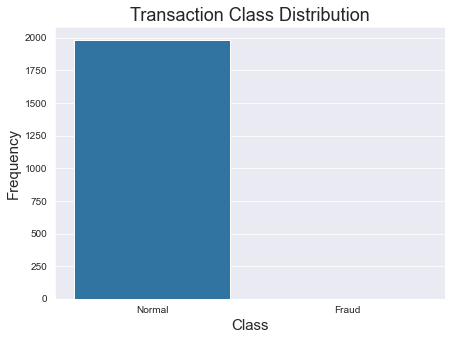

In [20]:
sns.countplot(df.Class)
LABELS = ["Normal", "Fraud"]
plt.title('Transaction Class Distribution',fontsize = 18)
plt.xticks(range(2), LABELS) 
plt.xlabel("Class" , fontsize =15)
plt.ylabel("Frequency",fontsize = 15)
plt.show()

We can observe that , the given data is highly imbalanced.

In [21]:
#checking the correlation
corr = df.corr()
corr


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
Time,1.000000,-0.086516,0.064974,-0.018857,-0.112753,-0.053317,-0.101996,0.023565,0.002004,0.033938,...,-0.014849,-0.077452,-0.004773,0.025261,-0.028303,0.064730,0.045917,0.068435,-0.006820,-0.022664
V1,-0.086516,1.000000,-0.170626,-0.161332,0.218990,-0.048667,-0.055608,-0.276513,0.171123,-0.169272,...,-0.107326,-0.047327,-0.105271,0.000225,0.331943,-0.043308,-0.100420,0.056113,-0.240069,-0.056174
V2,0.064974,-0.170626,1.000000,0.059168,-0.006511,0.197749,-0.135745,0.032906,-0.088379,0.082943,...,0.091203,-0.107963,0.030721,0.000252,-0.184657,-0.056278,0.102720,-0.050860,-0.514353,-0.024171
V3,-0.018857,-0.161332,0.059168,1.000000,0.115713,0.110067,-0.195126,-0.169739,0.015216,0.020276,...,0.043319,0.263435,0.061397,0.059592,-0.325131,0.065190,-0.229509,-0.231456,-0.338641,-0.034765
V4,-0.112753,0.218990,-0.006511,0.115713,1.000000,-0.114987,0.119386,0.084542,0.107317,-0.148339,...,-0.092961,0.097871,0.019255,0.034375,0.060462,-0.076467,0.009044,0.106346,0.118322,0.075246
V5,-0.053317,-0.048667,0.197749,0.110067,-0.114987,1.000000,-0.054499,-0.380770,0.139512,0.041055,...,0.068208,-0.126446,0.056470,-0.065028,-0.071435,-0.130388,-0.205485,-0.269805,-0.622438,0.012384
V6,-0.101996,-0.055608,-0.135745,-0.195126,0.119386,-0.054499,1.000000,0.200204,0.005896,0.011525,...,-0.012042,0.043275,-0.127263,-0.027506,0.074569,0.031155,0.055979,0.089813,0.407692,-0.032304
V7,0.023565,-0.276513,0.032906,-0.169739,0.084542,-0.380770,0.200204,1.000000,-0.131377,-0.025969,...,-0.221356,0.039687,-0.112218,0.022006,-0.115666,-0.012116,0.088389,0.027804,0.655326,-0.034638
V8,0.002004,0.171123,-0.088379,0.015216,0.107317,0.139512,0.005896,-0.131377,1.000000,-0.166914,...,-0.334942,0.075518,-0.019831,-0.020034,0.002046,0.052048,0.098324,0.151692,-0.163312,0.023692
V9,0.033938,-0.169272,0.082943,0.020276,-0.148339,0.041055,0.011525,-0.025969,-0.166914,1.000000,...,0.058726,0.030839,-0.084698,-0.008371,0.119762,0.077574,-0.039341,-0.229936,-0.053810,-0.054104


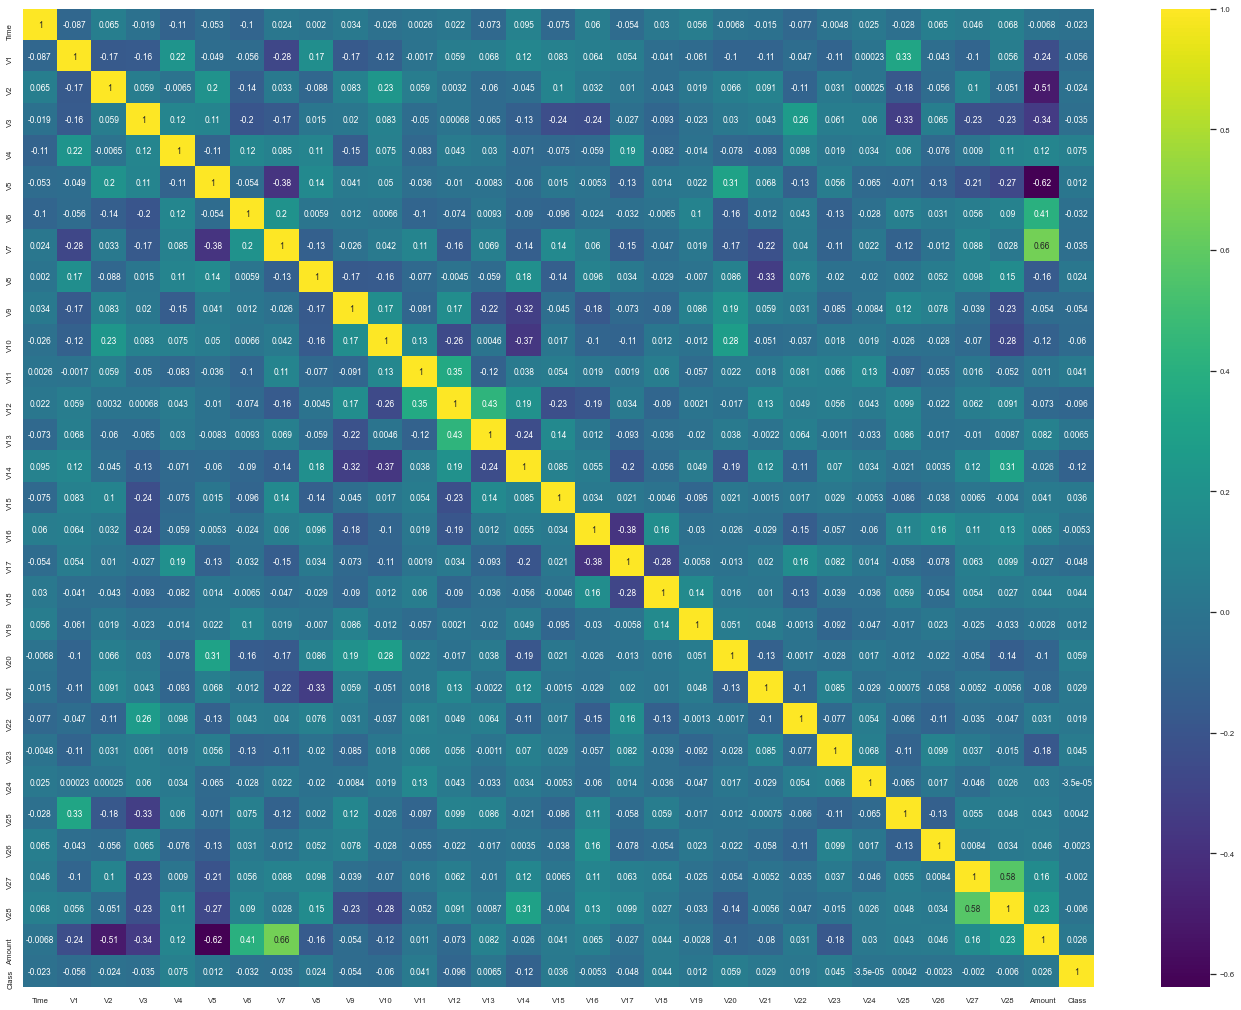

In [22]:
#Checking the correlation in heatmap
plt.figure(figsize =(24,18))
sns.set(font_scale=0.7)
sns.heatmap(corr ,cmap ='viridis' , annot = True )
plt.show()
     

In [23]:
##To get the normal and fraud dataset

fraud = df[df['Class']==1]

normal = df[df['Class']== 0]

In [24]:
print(fraud.shape , normal.shape)

(2, 31) (1983, 31)


Now , we need to analyze more amount of information from the transaction data.Like how different are the amount of money used in different transaction classes.

In [25]:
#for the fraud class
fraud.Amount.describe()

count      2.000000
mean     264.500000
std      374.059487
min        0.000000
25%      132.250000
50%      264.500000
75%      396.750000
max      529.000000
Name: Amount, dtype: float64

In [26]:
#for the normal class
normal.Amount.describe()

count    1983.000000
mean       68.404892
std       241.572682
min         0.000000
25%         4.950000
50%        15.090000
75%        63.285000
max      7712.430000
Name: Amount, dtype: float64

In [27]:
## Taking some sample of the data

df1= df.sample(frac = 0.1,random_state=1)

df1.shape

(199, 31)

In [28]:
df.shape

(1986, 31)

In [29]:
#Determine the number of fraud and valid transactions in the dataset

Fraud = df1[df1['Class']==1]

Valid = df1[df1['Class']==0]

outlier_fraction = len(Fraud)/float(len(Valid))

In [30]:
print(outlier_fraction)
print('Fraud Cases :', len(Fraud))
print('valid Cases :', len(Valid))

0.005050505050505051
Fraud Cases : 1
valid Cases : 198


Creating Dependent and Independent features

In [31]:
#Creating a random state
state = np.random.RandomState(42)

In [32]:
#Dependent feature

Y = df1['Class']
Y

1548    0.0
1545    0.0
1178    0.0
111     0.0
561     0.0
       ... 
1313    0.0
1890    0.0
1440    0.0
1882    0.0
970     0.0
Name: Class, Length: 199, dtype: float64

In [33]:

#Independent features
X = df1.drop(['Class'] , axis = 1)
X

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
1548,1216,1.231345,-0.023375,-0.333902,0.893327,0.598923,1.089545,-0.172479,0.330924,0.393031,...,-0.215534,-0.178722,-0.395878,-0.274231,-1.746339,0.806781,-0.217701,0.022302,-0.014272,13.99
1545,1213,-0.416579,0.186882,0.846414,0.515880,2.112431,4.683822,-0.261075,0.956504,0.647311,...,0.185880,-0.418328,-0.777743,-0.083653,1.004223,-0.191724,-0.492483,-0.072977,-0.054622,36.03
1178,919,0.904289,-0.538055,0.396058,0.500680,-0.864473,-0.657199,0.027231,-0.029473,0.265447,...,0.157346,-0.099460,-0.597579,-0.048666,0.551824,0.182934,0.402176,-0.081357,0.027252,158.00
111,73,1.148187,0.085837,0.120702,1.126665,0.214711,0.537381,-0.049989,0.186175,0.111781,...,-0.148395,-0.091112,-0.095475,-0.166750,-0.653433,0.713020,-0.288035,0.031507,0.000372,19.77
561,421,1.166913,-0.023367,0.624394,0.781791,-0.655557,-0.516614,-0.158570,0.033648,0.287207,...,-0.148655,-0.172050,-0.390215,0.030233,0.562816,0.373740,0.240428,-0.030839,0.004149,10.69
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1313,1029,-2.582175,2.213807,1.749030,-2.389200,0.713566,-0.214627,1.962399,-1.415934,3.074449,...,2.187643,-0.757745,0.042332,-0.220885,0.020242,-0.015996,0.556129,0.226622,-0.904042,0.92
1890,1460,-0.959399,0.542387,1.794987,-0.452459,-0.070080,-0.391800,0.622554,0.199171,0.357840,...,0.021657,-0.329376,-0.971206,-0.146850,-0.173983,0.392329,0.262252,0.204511,0.113103,44.60
1440,1117,0.956173,-0.403827,0.348913,0.625389,-0.672878,-0.714691,0.224837,-0.250195,0.389038,...,0.268209,-0.137629,-0.502776,-0.124889,0.463290,0.386684,0.483164,-0.061571,0.037350,158.00
1882,1450,-0.669051,1.137969,1.169320,-0.147124,0.196541,-0.234215,0.461928,0.258223,-0.372344,...,0.176081,-0.223611,-0.536028,0.014242,-0.053043,-0.233447,0.091225,0.364371,0.142858,3.59


In [34]:
X_outliers = state.uniform(low = 0 ,high = 1 , size =(X.shape[0],X.shape[1]))

In [35]:
print(X.shape)
print(Y.shape)

(199, 30)
(199,)


## Model Building and prediction

The algorithms that are used here to try to do the anomaly detection on this dataset are

1.Isolation Forest Algorithm

2.Local Outlier Factor(LOF) Algorithm 

3.Support Vector Machine (SVM) Algorithm

In [36]:
#Define the outlier detection method

classifiers = {
    "Isolation Forest":IsolationForest(n_estimators=100, max_samples=len(X), 
                                       contamination=outlier_fraction,random_state=state, verbose=0),
    "Local Outlier Factor":LocalOutlierFactor(n_neighbors=20, algorithm='auto', 
                                              leaf_size=30, metric='minkowski',
                                              p=2, metric_params=None, contamination=outlier_fraction),
    "Support Vector Machine":OneClassSVM(kernel='rbf', degree=3, gamma=0.1,nu=0.05, 
                                         max_iter=-1)
   
}

In [37]:

type(classifiers)

dict

In [38]:

n_outliers = len(Fraud)
for i ,(clf_name ,clf) in enumerate(classifiers.items()) :

  if clf_name == 'Isolation Forest':
    clf.fit(X)
    y_pred = clf.predict(X)
    scores_prediction = clf.decision_function(X)

  elif clf_name == 'Local Outlier Factor' :
    y_pred = clf.fit_predict(X)
    scores_prediction = clf.negative_outlier_factor_
  else:
     clf.fit(X)
     y_pred = clf.predict(X)

    #Reshape the prediction values to 0 for Valid transactions , 1 for Fraud transactions

  y_pred[y_pred == 1] = 0
  y_pred[y_pred == -1] = 1
  n_errors = (y_pred != Y).sum()

     #Run the classification metrics

  print("{}: {}".format(clf_name,n_errors))
  print("Accuracy Score :")
  print(accuracy_score(Y,y_pred))
  print("Classification Report :")
  print(classification_report(Y,y_pred)) 

Isolation Forest: 2
Accuracy Score :
0.9899497487437185
Classification Report :
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99       198
         1.0       0.00      0.00      0.00         1

    accuracy                           0.99       199
   macro avg       0.50      0.50      0.50       199
weighted avg       0.99      0.99      0.99       199

Local Outlier Factor: 0
Accuracy Score :
1.0
Classification Report :
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       198
         1.0       1.00      1.00      1.00         1

    accuracy                           1.00       199
   macro avg       1.00      1.00      1.00       199
weighted avg       1.00      1.00      1.00       199

Support Vector Machine: 126
Accuracy Score :
0.36683417085427134
Classification Report :
              precision    recall  f1-score   support

         0.0       1.00      0.36      0.53       198

In [39]:

import pickle

In [40]:
pickle.dump(IsolationForest ,open('IsoForest.pkl','wb'))

## Conclusion And Observation

Isolation Forest detected 73 errors versus Local Outlier Factor detecting 97 errors vs. SVM detecting 8516 error.

Isolation Forest has a 99.74% more accurate than LOF of 99.65% and SVM of 70.09%.

When comparing error precision & recall for 3 models , the Isolation Forest performed much better than the LOF as we can see that the detection of fraud cases is around 27 % versus LOF detection rate of just 2 % and SVM of 0%.

So overall Isolation Forest Method performed much better in determining the fraud cases which is around 30%.

We can also improve on this accuracy by increasing the sample size.